<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Working-with-spatial-features---ÜBERARBEITEN" data-toc-modified-id="Working-with-spatial-features---ÜBERARBEITEN-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Working with spatial features - ÜBERARBEITEN</a></span><ul class="toc-item"><li><span><a href="#Map-matching" data-toc-modified-id="Map-matching-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Map matching</a></span></li><li><span><a href="#Rating-spatial-information" data-toc-modified-id="Rating-spatial-information-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Rating spatial information</a></span></li><li><span><a href="#A-second-example-considering-areas" data-toc-modified-id="A-second-example-considering-areas-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>A second example considering areas</a></span><ul class="toc-item"><li><span><a href="#Exercise" data-toc-modified-id="Exercise-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Exercise</a></span></li></ul></li></ul></li></ul></div>

# Working with spatial features - ÜBERARBEITEN
Available data is not necessary useful, but need further modelling to be meaningful. 

In [5]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt 
import contextily
import osmnx as ox
from IPython.display import Image

%matplotlib inline
ox.config(log_console=True)
ox.__version__

'1.0.1'

First, we need to load a file, here one, that contains points in forest. When plotting the file, the visualization does not say much.

In [2]:
kn_ac = gpd.read_file(r'./data/knotenpunkte-wald_ac.geojson')
kn_ac.head()
kn_ac.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        82 non-null     object  
 1   knotennr  82 non-null     int64   
 2   geometry  82 non-null     geometry
dtypes: geometry(1), int64(1), object(1)
memory usage: 2.0+ KB


<AxesSubplot:>

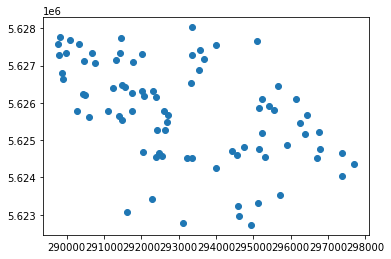

In [3]:
kn_ac.plot()

In [4]:
kn_ac = kn_ac.to_crs("EPSG:4326")
kn_ac.head()

,id,knotennr,geometry
0,knotenpunkte.1,4,POINT (6.07890 50.76305)
1,knotenpunkte.2,19,POINT (6.10303 50.75383)
2,knotenpunkte.3,14,POINT (6.07006 50.75377)
3,knotenpunkte.4,16,POINT (6.06168 50.74572)
4,knotenpunkte.5,15,POINT (6.06156 50.74399)


## Map matching
First, we need to query all the points of interest (POI) within the area our points cover. Next we require a polygon, that covers all the node ('Knotenpunkte'). Convex Hull is the smallest polygon that covers all points in the set. Based on this polygon we then use OpenStreeMap data to search for specific information. Points of interest within a specific domain, here parking.

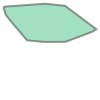

In [5]:
kn_ch = kn_ac.unary_union.convex_hull
kn_ch

In [6]:
%%time

pois = ox.geometries_from_polygon(
    kn_ch, tags={"amenity": 'parking'}
)
kn_ac = kn_ac.to_crs("EPSG:3857")
pois = pois.to_crs("EPSG:3857")


Wall time: 328 ms


After getting our parking data from OSM, we group and count them. Furthermore, we need to add them to put them to together in a plot and underlay a Basemap. 

In [7]:
pois.groupby('amenity').amenity.count()

C:\Users\kremer\Anaconda3\envs\p38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


amenity
parking    129
Name: amenity, dtype: int64

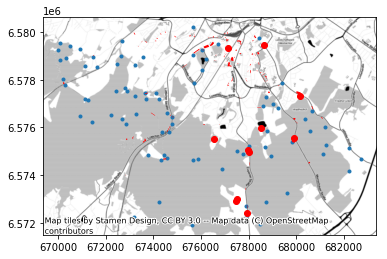

In [8]:
f,ax = plt.subplots(1)
kn_ac.plot(ax=ax, marker='.')
pois.plot(ax=ax, color='r')
contextily.add_basemap(
    ax, 
    crs=kn_ac.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)

In [9]:
kn_ac.crs

C:\Users\kremer\Anaconda3\envs\p38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
pois.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Rating spatial information
So far the information does not say much, it just gives us information about locations. To rate the information what is more or less valuable, we need to clarify the conditions. A node ('Knotenpunkt') is high rated when there is a lot of parking within the 500 m. It is a spatial join, as we link geometries based on spatial relationships/ predicates.

In [11]:
kn_albers = kn_ac.to_crs(epsg=3311)
kn_albers.head(20)

,id,knotennr,geometry
0,knotenpunkte.1,4,POINT (6710220.721 6663696.547)
1,knotenpunkte.2,19,POINT (6711604.775 6665168.286)
2,knotenpunkte.3,14,POINT (6711037.163 6662832.613)
3,knotenpunkte.4,16,POINT (6711733.438 6662032.115)
4,knotenpunkte.5,15,POINT (6711911.990 6661979.463)
5,knotenpunkte.6,55,POINT (6712039.413 6661668.507)
6,knotenpunkte.7,17,POINT (6711595.573 6661938.037)
7,knotenpunkte.8,68,POINT (6711115.108 6661465.630)
8,knotenpunkte.9,76,POINT (6710961.539 6661456.183)
9,knotenpunkte.10,77,POINT (6710780.368 6661004.284)


In [12]:
pois_albers = pois.to_crs(epsg=3311)
pois_albers.head()

C:\Users\kremer\Anaconda3\envs\p38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,unique_id,osmid,element_type,access,amenity,created_by,fee,parking,geometry,surface,...,roof:levels,roof:shape,toilets:wheelchair,operator:type,addr:city,addr:housenumber,addr:postcode,addr:street,lit,access:disabled
0,node/35345077,35345077,node,yes,parking,Potlatch 0.5a,no,surface,POINT (6712588.201 6664332.211),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node/35852897,35852897,node,yes,parking,NaN,no,surface,POINT (6713067.397 6665154.628),asphalt,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node/194380766,194380766,node,NaN,parking,NaN,NaN,NaN,POINT (6713114.613 6663864.778),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node/194380768,194380768,node,NaN,parking,NaN,NaN,NaN,POINT (6713053.328 6663874.950),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node/303997760,303997760,node,NaN,parking,NaN,NaN,NaN,POINT (6712560.072 6663011.553),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Around each Knotenpunkt node, we set a radius of 500m. Next we compute the pairs of relations between the two information.

In [13]:
kn_albers['buffer_500m'] = kn_albers.buffer(500)
kn_albers.head()

C:\Users\kremer\Anaconda3\envs\p38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,knotennr,geometry,buffer_500m
0,knotenpunkte.1,4,POINT (6710220.721 6663696.547),"POLYGON ((6710720.721 6663696.547, 6710718.313..."
1,knotenpunkte.2,19,POINT (6711604.775 6665168.286),"POLYGON ((6712104.775 6665168.286, 6712102.367..."
2,knotenpunkte.3,14,POINT (6711037.163 6662832.613),"POLYGON ((6711537.163 6662832.613, 6711534.755..."
3,knotenpunkte.4,16,POINT (6711733.438 6662032.115),"POLYGON ((6712233.438 6662032.115, 6712231.031..."
4,knotenpunkte.5,15,POINT (6711911.990 6661979.463),"POLYGON ((6712411.990 6661979.463, 6712409.582..."


In [17]:
joined = gpd.sjoin(
    pois_albers,
    kn_albers.set_geometry('buffer_500m')[['id', 'buffer_500m']],
    op="within"
).reset_index()
joined.head()

C:\Users\kremer\Anaconda3\envs\p38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,index,unique_id,osmid,element_type,access,amenity,created_by,fee,parking,geometry,...,toilets:wheelchair,operator:type,addr:city,addr:housenumber,addr:postcode,addr:street,lit,access:disabled,index_right,id
0,0,node/35345077,35345077,node,yes,parking,Potlatch 0.5a,no,surface,POINT (6712588.201 6664332.211),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71,knotenpunkte.72
1,1,node/35852897,35852897,node,yes,parking,NaN,no,surface,POINT (6713067.397 6665154.628),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55,knotenpunkte.56
2,34,way/41221501,41221501,way,yes,parking,NaN,no,surface,"POLYGON ((6713146.161 6665132.362, 6713172.696...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55,knotenpunkte.56
3,1,node/35852897,35852897,node,yes,parking,NaN,no,surface,POINT (6713067.397 6665154.628),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56,knotenpunkte.57
4,13,way/16301932,16301932,way,NaN,parking,NaN,NaN,NaN,"POLYGON ((6712714.116 6666015.602, 6712722.487...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56,knotenpunkte.57


Next we count how many parking areas are within the reach of 500m of each node (Knotenpunkt).

In [18]:
poi_count = joined.groupby("id")\
                  ["osmid"]\
                  .count()\
                  .to_frame('poi_count')
poi_count.head(5)


C:\Users\kremer\Anaconda3\envs\p38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,poi_count
id,
knotenpunkte.1,29
knotenpunkte.12,1
knotenpunkte.15,1
knotenpunkte.16,1
knotenpunkte.2,6


Now, we add the generated information to our original DataFrame. The last step is the visualization. Depending on the poi_count number for each node (Knotenpunkt) a colour schema is defined. And to localize each point we underlay a basemap.

In [26]:
kn_w_counts = kn_albers.merge(
    poi_count, left_on='id', right_index=True
).fillna({"poi_count": 0})
kn_w_counts.head(80)

,id,knotennr,geometry,buffer_500m,poi_count
0,knotenpunkte.1,4,POINT (6710220.721 6663696.547),"POLYGON ((6710720.721 6663696.547, 6710718.313...",29
1,knotenpunkte.2,19,POINT (6711604.775 6665168.286),"POLYGON ((6712104.775 6665168.286, 6712102.367...",6
3,knotenpunkte.4,16,POINT (6711733.438 6662032.115),"POLYGON ((6712233.438 6662032.115, 6712231.031...",3
4,knotenpunkte.5,15,POINT (6711911.990 6661979.463),"POLYGON ((6712411.990 6661979.463, 6712409.582...",3
5,knotenpunkte.6,55,POINT (6712039.413 6661668.507),"POLYGON ((6712539.413 6661668.507, 6712537.006...",1
6,knotenpunkte.7,17,POINT (6711595.573 6661938.037),"POLYGON ((6712095.573 6661938.037, 6712093.166...",5
7,knotenpunkte.8,68,POINT (6711115.108 6661465.630),"POLYGON ((6711615.108 6661465.630, 6711612.701...",3
8,knotenpunkte.9,76,POINT (6710961.539 6661456.183),"POLYGON ((6711461.539 6661456.183, 6711459.131...",1
11,knotenpunkte.12,26,POINT (6710180.703 6661367.842),"POLYGON ((6710680.703 6661367.842, 6710678.296...",1
14,knotenpunkte.15,29,POINT (6709994.019 6660332.568),"POLYGON ((6710494.019 6660332.568, 6710491.611...",1


C:\Users\kremer\Anaconda3\envs\p38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


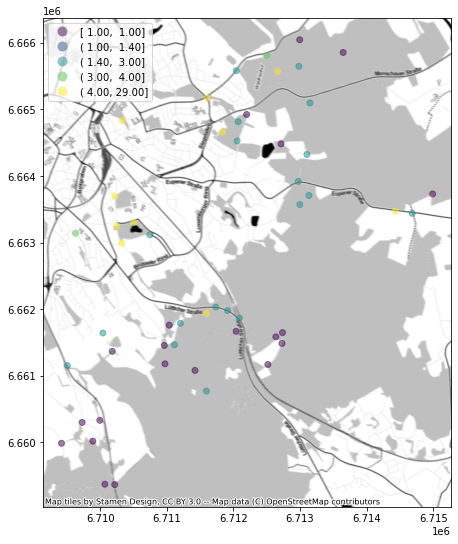

In [20]:
f, ax = plt.subplots(1, figsize=(9, 9))
kn_w_counts.plot(column="poi_count",
                      scheme="quantiles",
                      alpha=0.5,
                      legend=True,
                      ax=ax
                     )
contextily.add_basemap(ax, 
                       crs=kn_albers.crs.to_string(), 
                       source=contextily.providers.Stamen.Toner
                      )

## A second example considering areas
We do another example using the area 'Umweltzone' which contains the Aachen city centre.

In [6]:
uz = gpd.read_file("./data/umweltzone.shp")
uz.head()
uz.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          0 non-null      object  
 1   umweltzone  1 non-null      object  
 2   geometry    1 non-null      geometry
dtypes: geometry(1), object(2)
memory usage: 152.0+ bytes


<AxesSubplot:>

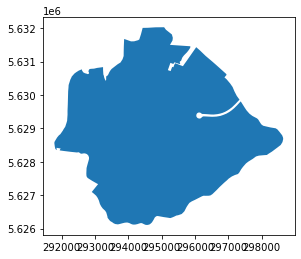

In [7]:
uz.plot()

In [8]:
uz = uz.to_crs("EPSG:4326")
uz.head()

,id,umweltzone,geometry
0,None,Umweltzone,"POLYGON ((6.08071 50.79995, 6.08121 50.80016, ..."


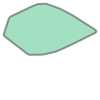

In [9]:
uz_ch = uz.unary_union.convex_hull
uz_ch

In [10]:
%%time
pois = ox.geometries_from_polygon(
    uz_ch, tags={"amenity": 'parking'}
)
uz = uz.to_crs("EPSG:3857")
pois = pois.to_crs("EPSG:3857")

Wall time: 429 ms


In [11]:
pois.groupby('amenity').amenity.count()

C:\Users\kremer\Anaconda3\envs\p38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


amenity
parking    669
Name: amenity, dtype: int64

In [ ]:
f,ax = plt.subplots(1,figsize=(12, 12))
uz.plot(ax=ax, marker='.')
pois.plot(ax=ax, color='r')
contextily.add_basemap(
    ax, 
    crs=uz.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)

### Exercise 
Take a look at the second example. Centroid the polygon and figure out how many parking areas are within 50, 100, 150, 200 meter.